# Gaussian Naive Bayes Classifier

Neke od biblioteka i unos podataka:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
data=pd.read_csv("C:/Users/ekodren/Desktop/faks/strojno/projekt/creditcard.csv")

Skaliranje neskaliranih značajki Time i Amount:

In [3]:
from sklearn.preprocessing import StandardScaler, RobustScaler
std_scaler = StandardScaler()
rob_scaler = RobustScaler()
data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))
data.drop(['Time','Amount'], axis=1, inplace=True)

In [4]:
scaled_amount = data['scaled_amount']
scaled_time = data['scaled_time']

data.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
data.insert(0, 'scaled_amount', scaled_amount)
data.insert(1, 'scaled_time', scaled_time)

In [5]:
X_all=data.drop(columns="Class")
y_all=data['Class']
number_of_frauds=sum(y_all)
class_names = ['not_fraud', 'fraud']

Funkcije za ispis konfuzijske matrice:

In [6]:
def ConfMatrix(y_test, y_pred):
    matrix = confusion_matrix(y_test, y_pred)
    dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
    sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
    plt.title("Confusion Matrix"), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

Podjela na test set i train set u omjeru 30:70

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3)

# Undersampling metoda

Prvo undersampling metodom balansiramo train set podataka:

In [8]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

Treniranje Gaussian Naive Bayesovog klasifikatora sa 15 različitih parametara:

In [61]:
br_param=15
parameters_us = np.linspace(1e-20, 1e-1, num=br_param) 
prec_us=np.empty(br_param); recall_us=np.empty(br_param); f_score_us=np.empty(br_param)
for i in range(br_param):
    gnb = GaussianNB(var_smoothing=parameters_us[i])
    gnb.fit(X_train_us, y_train_us)
    y_pred= gnb.predict(X_test)
    prec_us[i],recall_us[i],f_score_us[i],_=precision_recall_fscore_support(y_test, y_pred, average='binary')

Grafčki prikaz rezultata:


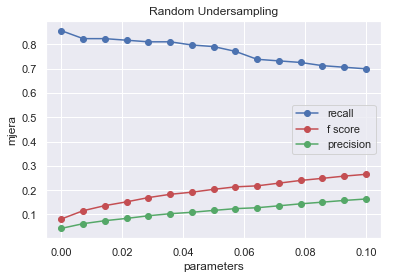

In [62]:
plt.figure(1)
plt.plot(parameters_us, recall_us,marker='o',color='b',label='recall')
plt.plot(parameters_us, f_score_us,marker='o',color='r', label='f score')
plt.plot(parameters_us, prec_us, marker='o',color='g', label='precision')
plt.xlabel('parameters')
plt.ylabel('mjera')
plt.title("Random Undersampling")
plt.legend()


GridSearch metodom tražimo najbolje parametre:

In [8]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score

In [59]:
br_param_var=10
br_param_rus=5
pipe=Pipeline([('rus',RandomUnderSampler()),('classifier', GaussianNB())])
rus_param_range=np.linspace(0.05, 0.2, num=br_param_var)
param_range=np.linspace(0.02, 0.08, num=br_param_rus)
param_grid=[{'classifier__var_smoothing':param_range,'rus__sampling_strategy':rus_param_range}]
gs=GridSearchCV(estimator=pipe, param_grid=param_grid,scoring='recall',cv=2, n_jobs=1, verbose=10)
gs=gs.fit(X_train,y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   29.3s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   31.1s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   32.1s
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:   34.6s
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   36.6s
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   39.2s
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   41.8s
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed:   44.9s
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:   48.1s
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed:   51.9s
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed:   56.3s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   58.8s finished


{'classifier__var_smoothing': 0.02, 'rus__sampling_strategy': 0.16666666666666669}


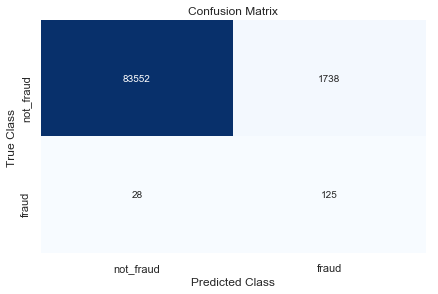

Recall:  0.8169934640522876
Precison:  0.06709608158883522
F-score:  0.12400793650793653


In [63]:
print(gs.best_params_)
gs_best_estimator=gs.best_estimator_
bla=gs_best_estimator.fit(X_train,y_train)
y_pred=bla.predict(X_test)
ConfMatrix(y_test,y_pred)
p,r,f,_=precision_recall_fscore_support(y_test, y_pred, average='binary')
print("Recall: ",r)
print("Precison: ",p)
print("F-score: ",f)

# Oversampling metoda

Na isti način kao i ranije, prvo oversampling metodom balansiramo set podataka, dijelimo na train set i test set u omjeru 70:30, te zatim treniramo Gaussian Naive Bayesovu metodu na različitim parametarima i to prikazujemo grafički, a zatim metodu optimiziramo GridSearchom:

In [8]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_train_os, y_train_os = ros.fit_sample(X_train, y_train)

In [57]:
br_param=10
parameters_os = np.linspace(1e-17, 1e-1, num=br_param) 
prec_os=np.empty(br_param); recall_os=np.empty(br_param); f_score_os=np.empty(br_param)
for i in range(10):
    gnb = GaussianNB(var_smoothing=parameters_os[i])
    gnb.fit(X_train_os, y_train_os)
    y_pred= gnb.predict(X_test)
    prec_os[i],recall_os[i],f_score_os[i],_=precision_recall_fscore_support(y_test, y_pred, average='binary')
  

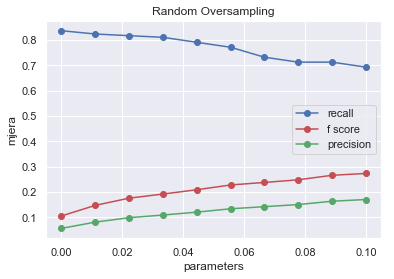

In [58]:
plt.figure(2)
plt.plot(parameters_os, recall_os,marker='o',color='b',label='recall')
plt.plot(parameters_os, f_score_os, marker='o',color='r', label='f score')
plt.plot(parameters_os, prec_os, marker='o',color='g', label='precision')
plt.xlabel('parameters')
plt.ylabel('mjera')
plt.title("Random Oversampling")
plt.legend()

In [72]:
br_param_rus=5
br_param_var=10
pipe=Pipeline([('ros',RandomOverSampler()),('classifier', GaussianNB())])
rus_param_range=np.linspace(0.07, 0.2, num=br_param_rus)
param_range=np.linspace(0.01,0.2, num=br_param_var)
param_grid=[{'classifier__var_smoothing':param_range,'ros__sampling_strategy':rus_param_range}]
gs=GridSearchCV(estimator=pipe, param_grid=param_grid,scoring='recall',cv=2, n_jobs=1, verbose=10)
gs=gs.fit(X_train,y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    3.5s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    5.4s
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:    8.6s
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   11.6s
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   15.5s
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   19.8s
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed:   24.9s
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:   29.5s
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed:   35.2s
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed:   40.6s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   43.6s finished


{'classifier__var_smoothing': 0.01, 'ros__sampling_strategy': 0.07}


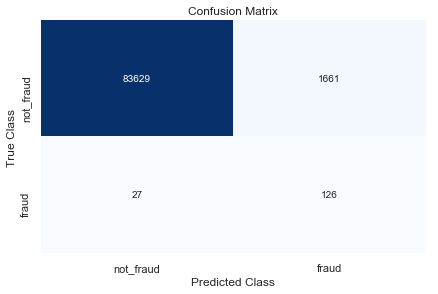

Recall:  0.8235294117647058
Precison:  0.07050923335198657
F-score:  0.12989690721649486


In [73]:
print(gs.best_params_)
gs_best_estimator=gs.best_estimator_
bla=gs_best_estimator.fit(X_train,y_train)
y_pred=bla.predict(X_test)
ConfMatrix(y_test,y_pred)
p,r,f,_=precision_recall_fscore_support(y_test, y_pred, average='binary')
print("Recall: ",r)
print("Precison: ",p)
print("F-score: ",f)

# Tomek Links metoda

In [9]:
from imblearn.under_sampling import TomekLinks
tomekl = TomekLinks(random_state=0,n_jobs=1)
X_train_tomekl, y_train_tomekl = tomekl.fit_sample(X_train, y_train)

In [12]:
br_param=10
parameters_tomekl = np.linspace(1e-19, 0.5, num=br_param) 
prec_tomekl=np.empty(br_param); recall_tomekl=np.empty(br_param); f_score_tomekl=np.empty(br_param)
for i in range(10):
    gnb = GaussianNB(var_smoothing=parameters_tomekl[i])
    gnb.fit(X_train_tomekl, y_train_tomekl)
    y_pred= gnb.predict(X_test)
    prec_tomekl[i],recall_tomekl[i],f_score_tomekl[i],_=precision_recall_fscore_support(y_test, y_pred, average='binary')

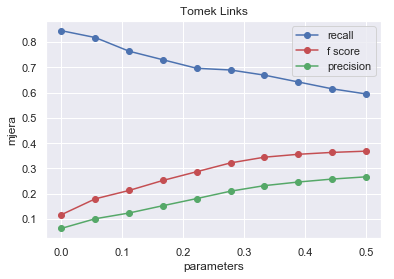

In [13]:
plt.figure(2)
plt.plot(parameters_tomekl, recall_tomekl,marker='o',color='b',label='recall')
plt.plot(parameters_tomekl, f_score_tomekl, marker='o',color='r', label='f score')
plt.plot(parameters_tomekl, prec_tomekl, marker='o',color='g', label='precision')
plt.xlabel('parameters')
plt.ylabel('mjera')
plt.title("Tomek Links")
plt.legend()

In [14]:
br_param_tomek=5
br_param_var=10
pipe=Pipeline([('tomek',TomekLinks()),('classifier', GaussianNB())])
param_range=np.linspace(0.01,0.2, num=br_param_var)
param_grid=[{'classifier__var_smoothing':param_range}]
gs=GridSearchCV(estimator=pipe, param_grid=param_grid,scoring='recall',cv=2, n_jobs=1, verbose=10)
gs=gs.fit(X_train,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] classifier__var_smoothing=0.01 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__var_smoothing=0.01, score=0.813953488372093, total= 3.4min
[CV] classifier__var_smoothing=0.01 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s


[CV]  classifier__var_smoothing=0.01, score=0.8313953488372093, total= 4.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  8.1min remaining:    0.0s


[CV] classifier__var_smoothing=0.03111111111111111 ...................
[CV]  classifier__var_smoothing=0.03111111111111111, score=0.8081395348837209, total= 3.6min
[CV] classifier__var_smoothing=0.03111111111111111 ...................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.7min remaining:    0.0s


[CV]  classifier__var_smoothing=0.03111111111111111, score=0.8197674418604651, total= 3.3min
[CV] classifier__var_smoothing=0.052222222222222225 ..................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 15.1min remaining:    0.0s


[CV]  classifier__var_smoothing=0.052222222222222225, score=0.8023255813953488, total= 3.6min
[CV] classifier__var_smoothing=0.052222222222222225 ..................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 18.6min remaining:    0.0s


[CV]  classifier__var_smoothing=0.052222222222222225, score=0.813953488372093, total= 3.3min
[CV] classifier__var_smoothing=0.07333333333333333 ...................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 22.0min remaining:    0.0s


[CV]  classifier__var_smoothing=0.07333333333333333, score=0.7732558139534884, total= 3.6min
[CV] classifier__var_smoothing=0.07333333333333333 ...................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 25.6min remaining:    0.0s


[CV]  classifier__var_smoothing=0.07333333333333333, score=0.7906976744186046, total= 3.4min
[CV] classifier__var_smoothing=0.09444444444444444 ...................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 28.9min remaining:    0.0s


[CV]  classifier__var_smoothing=0.09444444444444444, score=0.7558139534883721, total= 3.6min
[CV] classifier__var_smoothing=0.09444444444444444 ...................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 32.5min remaining:    0.0s


[CV]  classifier__var_smoothing=0.09444444444444444, score=0.7616279069767442, total= 3.3min
[CV] classifier__var_smoothing=0.11555555555555555 ...................
[CV]  classifier__var_smoothing=0.11555555555555555, score=0.6686046511627907, total= 3.4min
[CV] classifier__var_smoothing=0.11555555555555555 ...................
[CV]  classifier__var_smoothing=0.11555555555555555, score=0.686046511627907, total= 3.3min
[CV] classifier__var_smoothing=0.1366666666666667 ....................
[CV]  classifier__var_smoothing=0.1366666666666667, score=0.6627906976744186, total= 3.5min
[CV] classifier__var_smoothing=0.1366666666666667 ....................
[CV]  classifier__var_smoothing=0.1366666666666667, score=0.6453488372093024, total= 3.3min
[CV] classifier__var_smoothing=0.1577777777777778 ....................
[CV]  classifier__var_smoothing=0.1577777777777778, score=0.6453488372093024, total= 3.5min
[CV] classifier__var_smoothing=0.1577777777777778 ....................
[CV]  classifier__va

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 70.0min finished


{'classifier__var_smoothing': 0.01}


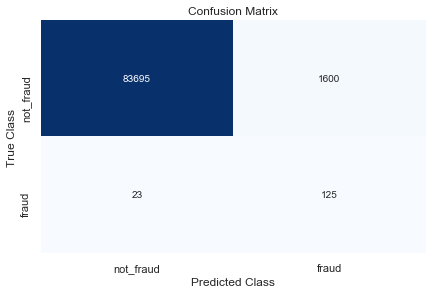

Recall:  0.8445945945945946
Precison:  0.07246376811594203
F-score:  0.13347570742124934


In [15]:
print(gs.best_params_)
gs_best_estimator=gs.best_estimator_
bla=gs_best_estimator.fit(X_train,y_train)
y_pred=bla.predict(X_test)
ConfMatrix(y_test,y_pred)
p,r,f,_=precision_recall_fscore_support(y_test, y_pred, average='binary')
print("Recall: ",r)
print("Precison: ",p)
print("F-score: ",f)